In [1]:
import numpy as np
import hydrogen as h2
import matplotlib.pyplot as plt

# High temperature electrolysis (HTE)

The following figure contains a basic diagram of a HTE unit coupled to a nuclear reactor.

https://www.sciencedirect.com/science/article/pii/S0149197007001709

More details in https://inldigitallibrary.inl.gov/sites/sti/sti/4480292.pdf

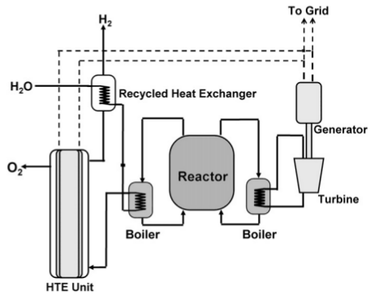

In [103]:
from wand.image import Image as WImage
img = WImage(filename='./figures/hte.png')
w, h = img.size
b = 300
a = int(w/h*b)
img.resize(a, b)
img

### Theoretical values

From Figure 8 of https://web.mit.edu/yildizgroup/LEI/assets/pdfs/bilge_ijhe_2006.pdf
we get the following values for $\Delta$G and T$\Delta$S.

Values are consistent with: https://janaf.nist.gov/tables/H-064.html

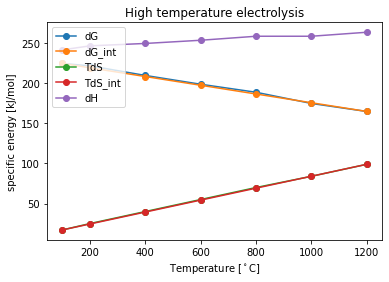

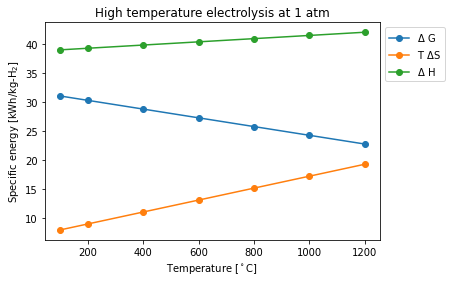

In [12]:
# Values from the report
dg_T = [225, 222, 210, 199, 189, 175, 165]  # [kJ/mol]
tds_T = [17, 25, 40, 55, 70, 84, 99]  # [kJ/mol]
temp = [100, 200, 400, 600, 800, 1000, 1200]  # [C]

# Linear interpolation using first and last values (T=100 & T=1200)
dg = [225, 165]  # [kJ/mol]
tds = [17, 99]  # [kJ/mol]
te = [100, 1200]  # [C]

dg_int = [np.interp(T, te, dg) for T in temp]
tds_int = [np.interp(T, te, tds) for T in temp]
# ds_int = np.array(tds_int)/(np.array(temp)+273)

plt.figure(1)
plt.plot(temp, dg_T, label='dG', marker='o')
plt.plot(temp, dg_int, label='dG_int', marker='o')
plt.plot(temp, tds_T, label='TdS', marker='o')
plt.plot(temp, tds_int, label='TdS_int', marker='o')
plt.plot(temp, np.array(dg_T)+np.array(tds_T), label='dH', marker='o')
plt.legend(loc="upper left")
plt.title('High temperature electrolysis')
plt.ylabel('specific energy [kJ/mol]')
plt.xlabel('Temperature [$^\circ$C]')

# Convert values to kWh/kg-H2
dg_int = np.array(dg_int)/3600/2/1.008/1e-3
tds_int = np.array(tds_int)
tds_int += 48.2 - 7.55 # vaporization energy at 1 atm
tds_int *= 1/3600/2/1.008/1e-3
dh_int = dg_int + tds_int

plt.figure(2)
plt.plot(temp, dg_int, label='$\Delta$ G', marker='o')
plt.plot(temp, tds_int, label='T $\Delta$S', marker='o')
plt.plot(temp, dh_int, label='$\Delta$ H', marker='o')
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), fancybox=True)
plt.title('High temperature electrolysis at 1 atm')
plt.ylabel('Specific energy [kWh/kg-H$_2$]')
plt.xlabel('Temperature [$^\circ$C]')
plt.savefig("figures/hte-energy", dpi=300, bbox_inches="tight")

Note for my future self:

T$\Delta$S (1000C) < 100 kJ/mol, and according to https://ieeexplore.ieee.org/abstract/document/5898382 such value should be 112.9 kJ/mol. In fig. 1 in https://www.sciencedirect.com/science/article/abs/pii/0360319980901147 T$\Delta$S (1000C) < 100 kJ/mol as well. So, I take these values to be right.
I know what is going on here. The second one considers the vaporization enthalpy. I should use that one.

### Some real numbers

T = 700-750C (Pressure = 5 bar), electrical energy=36.8kWh/kg, thermal energy=5.9kWh/kg, steam utilization 60%.

https://www.hydrogen.energy.gov/pdfs/review19/ta019_ghezel-ayagh_2019_o.pdf

T = 1050K = 780C, electrical energy = 51.02 kWh/kg-H$_2$, thermal energy = 10.66 kWh/kg-H$_2$.

https://www1.eere.energy.gov/solar/pdfs/doctor.pdf

T = 800C (Pressure = 3.5 MPa), P=18 kW, 5.7 Nm$^3$/h.

https://inldigitallibrary.inl.gov/sites/sti/sti/4480292.pdf

In [7]:
E = 18  # Energy [kWh]
M = 5.7*0.084 # Mass of H2 [kg]
se = E/M
print("Specific energy: ", se, "kWh/H2kg")  # Specific energy [kWh/kg]

Specific energy:  37.59398496240601 kWh/H2kg


T = 1000C, P=39.3 W, 17.6 Nl/h.

https://ieeexplore.ieee.org/abstract/document/5898382

In [8]:
E = 39.3e-3  # Energy [kWh]
M = 17.6*1e-3*0.084  # Mass of H2 [kg]
se = E/M
print("Specific energy: ", se, "kWh/kg-H2")  # Specific energy [kWh/kg]

Specific energy:  26.582792207792206 kWh/kg-H2


600 MWth gas cooled reactor could produce 85 million SCFD = 2.5 kg/s = 9000 kg/h = 216e3 kg/day... seems too much a priori.

https://www.energy.gov/sites/prod/files/2014/08/f18/fcto_2014_electrolytic_h2_wkshp_obrien1.pdf

In [2]:
def SCFD_to_kgps(quant):
    # [standard cft/d to kg/s]
    return quant/35.3147/3600/24*0.088

print(SCFD_to_kgps(85e6), 'kg/s')
print(2.5 * 3600 * 24, 'kg/day')

2.4515024642450327 kg/s
216000.0 kg/day


### Energy requirements

This sections calculates the energy requirements and also the production rate capacity for different reactor sizes.
Due to lack of accuracy on the real specific energy required to carry out the electrolysis, I will use the theoretical values instead of the real values. Future work should look into more accurate real values.

**Note for future self:**
How does the thermal-to-electrical efficiency affect the calculations?

#### Some Chemistry

Q - W = $\bar{h^\circ_c} + \sum_p n_p (\bar{h} - \bar{h^\circ})_p - \sum_r n_r (\bar{h} - \bar{h^\circ})_r$

(15-10) "Thermodynamics: An Engineering Approach" 7th Edition,Cengel

Data NIST:
* H$_2$O (g): https://webbook.nist.gov/cgi/cbook.cgi?ID=C7732185&Mask=1EBF&Type=JANAFG&Plot=on#JANAFG
* H$_2$ (g): https://webbook.nist.gov/cgi/cbook.cgi?ID=C1333740&Mask=1#Thermo-Gas
* O$_2$ (g): https://webbook.nist.gov/cgi/cbook.cgi?ID=C7782447&Mask=1#Thermo-Gas

More tables (NIST):
* https://janaf.nist.gov/
* https://janaf.nist.gov/tables/H-064.html

$\Delta$ S (T, P) = $\Delta$ S$^{\circ}$ (T, P$_{0}$ = 1atm) - R * $ln(P/P_{0}$)

### Thermal-to-electrical conversion efficiency

LWR 33%

GT-MHR:
https://www-pub.iaea.org/MTCD/Publications/PDF/TE_1674_CD_web.pdf

$T_o$ = 850 $^\circ$C, $\eta$ = 48%

$T_o$ = 950 $^\circ$C, $\eta$ = 52%

$\eta \simeq 0.68 \times \left( 1 - \frac{T_c}{T_H} \right)$


In [4]:
import hydrogen as h2

print(h2.efficiency(300))
print(h2.efficiency(850))
print(h2.efficiency(950))

0.32397905759162304
0.4983437221727516
0.5131970564186427


### HTE

Two cases of high temperature electrolysis (HTE) will be considered:
* HTE1: steam temperature reaches values that make HTE feasible, T $\in$ [600-900$^\circ$C] with the thermal heat given by the reactor. This case considers reactors which outlet temperatures $\in$ [600-900$^\circ$C].
* HTE2: steam temperature is boosted using resistive heating.

The system analysis of a HTE plant coupled to a nuclear reactor can get messy real quick. The following sections describe different cases that take into account an increasing degree of complexity.

We will consider that HTE has an electrical efficiency of an 88%. ( see LVH [1](http://www.helmeth.eu/index.php/technologies/high-temperature-electrolysis-cell-soec))


#### HTE 1

* T$_e$: temperature at which the electrolysis occurs.
* T$_o$: reactor outlet temperature.

For an outlet temperature of 850C, a 97% eficiency yields a maximum steam temperature of 827C. https://www.osti.gov/servlets/purl/814014

For this case T$_e$ = 0.97 T$_o$

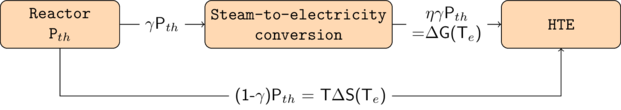

In [12]:
from wand.image import Image as WImage
img = WImage(filename='./figures/hte1-figure0.png')
w, h = img.size
b = 110
a = int(w/h*b)
img.resize(a, b)
img

The following cells highlight the importance of taking into account the pressure.

In [3]:
#This cell doesn't take into account pressure changes
p = 1 # [atm]
To = 850  # reactor outlet temperature
print("Required power: ", h2.hte_power_req(p, To)[0], "kWh/kg-H2")  # [kWh/kg]

Required power:  72.92024072749604 kWh/kg-H2


In [4]:
#This cell takes into account pressure changes
p = 3.5  # MPa
p *= 9.86923 # MPa -> atm
To = 850  # reactor outlet temperature

print("Required power: ", h2.hte_power_req(p, To)[0], "kWh/kg-H2")  # [kWh/kg]

Required power:  78.70859944144858 kWh/kg-H2


In the following figure, we see the effects of pressure changes on the energy requirements. Although $\Delta$H is not affected by the pressure variations, $\Delta$G and T$\Delta$S change. As $\Delta G$ increases, the total reactor power to produce 1kg of H$_2$ increases as well.

It may seem a poor choice to use high temperature electrolysis at high pressure, then. The reason why we chose a high pressure in the beginning is to save energy, as compressing liquid water is cheaper than compressing the hydrogen once it is produced.

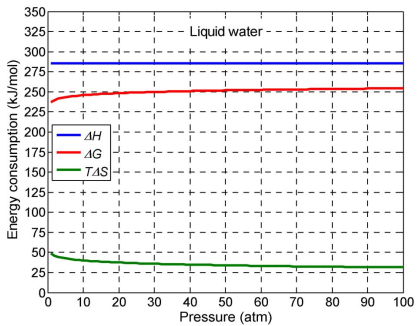

In [15]:
from IPython.display import Image
Image(filename='figures/hte-pressure.png')

31.65435005021187


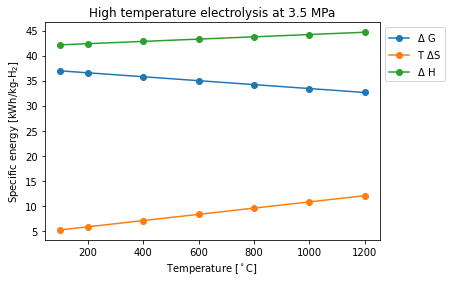

In [11]:
temp = np.array(temp)
dg = [225, 165]  # [kJ/mol]
tds = [17, 99]  # [kJ/mol]
te = [100, 1200]  # [C]

dg_int = np.array([np.interp(T, te, dg) for T in temp])
tds_int = np.array([np.interp(T, te, tds) for T in temp])
dh_int = dg_int + tds_int

p = 3.5  # MPa
p *= 9.86923 # MPa to atm
R = 8.314
tds_int -= R*(temp+273)*np.log(p)/1e3
dg_int = dh_int - tds_int
dg_int /= 0.88
tds_int += h2.delta_H(243, 242)
print(h2.delta_H(243, 242))

dg_int *= 1/3600/2/1.008/1e-3
tds_int *= 1/3600/2/1.008/1e-3
dh_int = dg_int + tds_int

plt.figure()
plt.plot(temp, dg_int, label='$\Delta$ G', marker='o')
plt.plot(temp, tds_int, label='T $\Delta$S', marker='o')
plt.plot(temp, dh_int, label='$\Delta$ H', marker='o')
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), fancybox=True)
plt.title('High temperature electrolysis at 3.5 MPa')
plt.ylabel('Specific energy [kWh/kg-H$_2$]')
plt.xlabel('Temperature [$^\circ$C]')
plt.savefig("figures/hte-energy-P", dpi=300, bbox_inches="tight")

[85.24594338462863, 83.24218074632925, 81.51880616929303, 80.02135174575783, 78.70859944144858, 77.54878311174666, 76.51702608330895]


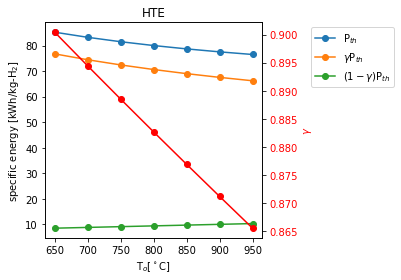

In [13]:
p = 3.5
p *= 9.86923 # MPa -> atm
Tol = [650, 700, 750, 800, 850, 900, 950]

Pl = [h2.hte_power_req(p, To)[0] for To in Tol]
print(Pl)
gl = [h2.hte_power_req(p, To)[1] for To in Tol]
gpl = np.array(gl) * np.array(Pl)
gcl = (1-np.array(gl)) * np.array(Pl)

fig, ax1 = plt.subplots()
ax1.plot(Tol, Pl, label='P$_{th}$', marker='o')
ax1.plot(Tol, gpl, label='$\gamma$P$_{th}$', marker='o')
ax1.plot(Tol, gcl, label='$(1-\gamma)$P$_{th}$', marker='o')
ax1.legend(loc="upper left", bbox_to_anchor=(1.2, 1.0), fancybox=True)
ax1.set_title("HTE", color="black")
ax1.set_ylabel("specific energy [kWh/kg-H$_2$]", color="black")
ax1.set_xlabel("T$_o$[$^\circ$C]")
ax2 = ax1.twinx()
ax2.plot(Tol, gl, color='red', marker="o")
ax2.set_ylabel('$\gamma$', color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
plt.savefig("figures/hte1-power", dpi=300, bbox_inches="tight")

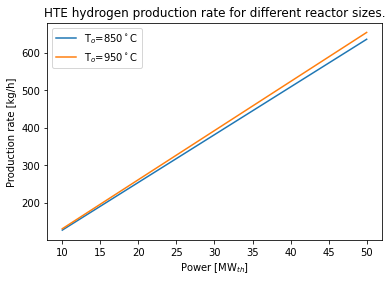

In [14]:
p = 3.5  # [MPa]
p *= 9.86923  # MPa -> atm
power = [10, 20, 30, 40, 50]  # [MW_{th}]

To1 = 850
prate1 = [h2.hte_prod_rate(Pt, p, To1)[0] for Pt in power]

To2 = 950
prate2 = [h2.hte_prod_rate(Pt, p, To2)[0] for Pt in power]

plt.plot(power, prate1, label='T$_o$={0}$^\circ$C'.format(To1))
plt.plot(power, prate2, label='T$_o$={0}$^\circ$C'.format(To2))
plt.legend(loc="upper left")
plt.title('HTE hydrogen production rate for different reactor sizes.')
plt.ylabel('Production rate [kg/h]')
plt.xlabel('Power [MW$_{th}$]')
plt.savefig("figures/hte-prodrate", dpi=300, bbox_inches="tight")

#### HTE2:

* T$_e$: temperature at which the electrolysis occurs.
* T$_o$: reactor outlet temperature.
* T$_r$: 97% of T$_o$.

$\eta \gamma P_{th} = \Delta G (T_e) + \Delta H(T_e, T_r)$

$(1 - \gamma) P_{th} = T\Delta S(T_r)$

$\Delta H(T_e, T_r) = T\Delta S(T_e) - T\Delta S(T_r)$

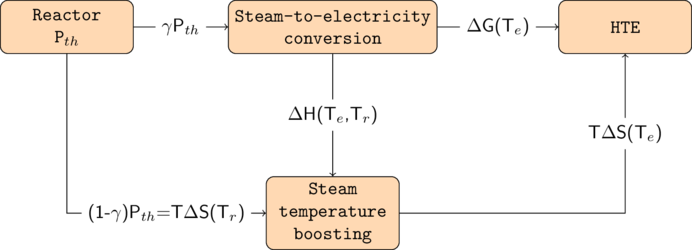

In [1]:
from wand.image import Image as WImage
img = WImage(filename='./figures/hte2-figure0.png')
w, h = img.size
b = 250
a = int(w/h*b)
img.resize(a, b)

img

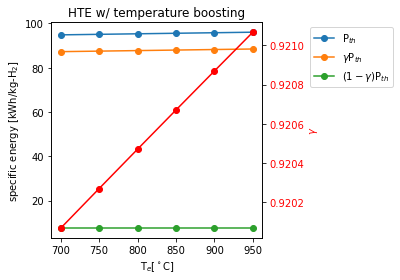

In [15]:
p = 3.5
p *= 9.86923  # MPa -> atm
To = 500
Tel = [700, 750, 800, 850, 900, 950]

pth = [h2.hte2_power_req(p, To, Te)[0] for Te in Tel]
gam = [h2.hte2_power_req(p, To, Te)[1] for Te in Tel]
gpl = np.array(gam) * np.array(pth)
gcl = (1-np.array(gam)) * np.array(pth)

fig, ax1 = plt.subplots()
ax1.plot(Tel, pth, label='P$_{th}$', marker='o')
ax1.plot(Tel, gpl, label='$\gamma$P$_{th}$', marker='o')
ax1.plot(Tel, gcl, label='$(1-\gamma)$P$_{th}$', marker='o')
ax1.legend(loc="upper left", bbox_to_anchor=(1.2, 1.0), fancybox=True)
ax1.set_title("HTE w/ temperature boosting", color="black")
ax1.set_ylabel("specific energy [kWh/kg-H$_2$]", color="black")
ax1.set_xlabel("T$_e$[$^\circ$C]")
ax2 = ax1.twinx()
ax2.plot(Tel, gam, color='red', marker="o")
ax2.set_ylabel('$\gamma$', color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
plt.savefig("figures/hte2-power", dpi=300, bbox_inches="tight")

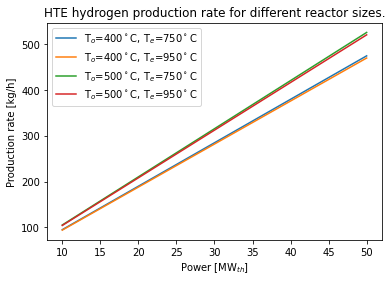

In [16]:
p = 3.5
p *= 9.86923  # MPa -> atm
power = [10, 20, 30, 40, 50]  # [MW_{th}]
To1 = 400  # reactor outlet temperature
Te1 = 750
Te2 = 950
To2 = 500

prate1 = [h2.hte2_prod_rate(Pt, p, To1, Te1)[0] for Pt in power]
prate2 = [h2.hte2_prod_rate(Pt, p, To1, Te2)[0] for Pt in power]
prate3 = [h2.hte2_prod_rate(Pt, p, To2, Te1)[0] for Pt in power]
prate4 = [h2.hte2_prod_rate(Pt, p, To2, Te2)[0] for Pt in power]

plt.plot(power, prate1, label='T$_o$={0}$^\circ$C, T$_e$={1}$^\circ$C'.format(To1, Te1))
plt.plot(power, prate2, label='T$_o$={0}$^\circ$C, T$_e$={1}$^\circ$C'.format(To1, Te2))
plt.plot(power, prate3, label='T$_o$={0}$^\circ$C, T$_e$={1}$^\circ$C'.format(To2, Te1))
plt.plot(power, prate4, label='T$_o$={0}$^\circ$C, T$_e$={1}$^\circ$C'.format(To2, Te2))

plt.legend(loc="upper left")
plt.title('HTE hydrogen production rate for different reactor sizes.')
plt.ylabel('Production rate [kg/h]')
plt.xlabel('Power [MW$_{th}$]')
plt.savefig("figures/hte2-prodrates", dpi=300, bbox_inches="tight")

### Future work

* I used the theoretical values in this work. Using real HTE values would be better, but there are note very accurate values in the literature. And I believe this is because the technology is not fully developed.
* consider $\gamma$ as an independent variable. Case where the reactor co-generates process heat and electricity.

### Other sources:
* https://pubs.rsc.org/en/content/articlelanding/2008/jm/b718822f/unauth#!divAbstract
* https://www.sciencedirect.com/science/article/pii/S0378775311024384
* https://www.sciencedirect.com/science/article/abs/pii/0360319988900523
* http://www.helmeth.eu/index.php/technologies/high-temperature-electrolysis-cell-soec

